## Lens-focused Laguerre-Gauss beam as per GLMT: <br></br>A Finite Series sketch

In [2]:
# Imports
import numpy as np               # Ye olde numpy
import scipy.special as sp       # Special functions
import matplotlib.pyplot as plt  # Plots results
import mpmath                    # Arbitrary precision
import scipy.integrate as intg   # Numerical integration

import inspect                   # Maybe remove later (decorator things)
import time                      # For performance evalution

In [3]:
mpmath.mp.dps = 50
integrationdps = 200

In [4]:
# LFLG beam parameters:
p, l = 0, 2
alpha, beta = 1, 0
r_focus = 1E-3
wavelength = 6328E-9
na = .95
w0 = 3.2 * wavelength

k = 2 * np.pi / wavelength
s = 1 / k / w0

parameters = {
    "p": p,
    "l": l,
    "alpha": alpha,
    "beta": beta,
    "r_focus": r_focus,
    "wavelength": wavelength,
    "na": na,
    "w0": w0,
    "delta": 1,
}

In [5]:
# Memoization decorator
def memoized(func):
    CACHE = {}
    def memoized_func(*args, **kwargs):
        kwvals = [val for _, val in kwargs.items()]
        if (*args, *kwvals) not in CACHE:
            value = func(*args, **kwargs)
            CACHE[(*args, *kwvals)] = value
            return value
        return CACHE[(*args, *kwvals)]
    return memoized_func

In [27]:
class LGBeamFS:
    def __init__(self, **kwargs):
        self.__dict__.update(parameters)
        self.__dict__.update(kwargs)
        
        self.k = 2 * np.pi / self.wavelength
        self.s = 1 / self.k / self.w0
        if 'delta' not in parameters and 'delta' not in kwargs:
            self.delta = 1
    
    def a(self, eta):
        return eta * self.r_focus * self.s * mpmath.sqrt(2)
    
    def lens_integrand(self, eta, n, p, kind='A'):
        if kind == 'E':
            return self.lens_integrand(eta, n + 1, p, kind='A')
        
        pm = 1 if kind == 'A' else -1
        if p == 0:
            lfactor = 1
        elif p >= 1:
            lfactor = mpmath.laguerre(p - 1, self.l, self.a(eta) ** 2) \
                    * self.a(eta) ** 2
        else:
            raise ValueError("Negative values of p are not acceptable.")
        
        kz_factor = mpmath.power(self.k ** 2 - eta ** 2, 1/ 4)
        if kind in ['A', 'B']:
            kz_factor = 1 / kz_factor
            power = n - 1
        elif kind in ['C', 'D']:
            kz_factor = kz_factor / self.k
            power = n - 2
        else: 
            raise ValueError("Only kinds A, B, C, D and E recognized.") 
        
        res = mpmath.power(eta, np.abs(l + 1)) \
            * kz_factor * lfactor * mpmath.exp(-self.a(eta) ** 2 / 2) \
            * (1 + pm * mpmath.sqrt(self.k ** 2 - eta ** 2) / self.k) \
            * mpmath.power(eta / k, power)
        return res
    
    def F(self, j, u):
        return (-1) ** ((j - u) / 2) \
             * mpmath.gammaprod([], [(j - u) / 2 + 1, (j + u) / 2 + 1])
    # / mpmath.factorial((j - u) / 2) / mpmath.factorial((j + u) / 2)
    
    @memoized
    def lens_integral(self, n, p, kind='A', intg_func=intg.quadrature):
        FUNCS = (intg.quad, intg.quadrature, intg.romberg, mpmath.quad)
        max_eta = self.k * self.na * self.delta
        np_lint = np.frompyfunc(self.lens_integrand, 4, 1)
        if intg_func not in FUNCS:
            raise ValueError("intg_func", intg_func, "not supported.")
        if intg_func is intg.quadrature:
            return intg_func(np_lint, 0, max_eta, args=(n, p, kind),
                             rtol=1E-64, maxiter=200)[0]
        elif intg_func is mpmath.quad:
            def lint(eta):
                return self.lens_integrand(eta, n, p, kind=kind)
            return intg_func(lint, [0, max_eta])
        elif intg_func is intg.romberg:
            return intg_func(np_lint, 0, max_eta, args=(n, p, kind),
                             rtol=1E-100)
        elif intg_func is intg.quad:
            return mpmath.mpc(intg.quad(np_lint, 0, max_eta, args=(n, p, kind),
                             epsrel=1E-200, limit=400)[0])
        else:
            raise NotImplemented(intg_func, "not supported")
        
    @memoized
    def maclaurin_nmevn(self, j, p, intg_func=intg.quad, m=0):
        lpart, rpart = 1, 1
        premul = 1j * np.sqrt(2 / np.pi) * (self.alpha + 1j * self.beta) \
               / mpmath.power(2, j)
        if j <= l:
            lpart = 0
            if j <= l - 2:
                rpart = 0

        if rpart != 0:
            rpart = self.F(j - 1, self.l - 2) \
                  * self.lens_integral(j, p, kind='B', intg_func=intg_func)
            if lpart != 0:
                lpart = self.F(j - 1, self.l) \
                      * self.lens_integral(j, 0, kind='A', intg_func=intg_func)
        if p == 1:
            if rpart != 0:
                rpart = self.F(j - 1, self.l - 2) \
                      * ((l + 1) * self.lens_integral(j, 0, kind='B',
                                                      intg_func=intg_func) \
                        - self.lens_integral(j, 1, kind='B'))
                if lpart != 0:
                    lpart = self.F(j - 1, self.l) \
                          * ((l + 1) * self.lens_integral(j, 0, kind='A', 
                                                          intg_func=intg_func) \
                            - self.lens_integral(j, 1, kind='A',
                                                 intg_func=intg_func))
        elif p != 0:
            premul = premul / p
            return ((2 * p - 1 + self.l) / p * self.maclaurin(j, p - 1,
                                                              intg_func=intg_func) \
                    - (p - 1 + self.l) / p * self.maclaurin(j, p - 2,
                                                           intg_func=intg_func) \
                    - premul * (lpart + rpart)
                   )
            
        return premul * (lpart + rpart)
    
    def odd_base(self, j, p, intg_func=intg.quad, m=0):
        if m == self.l - 1:
            upper_lim = l + 1
            lower_lim = l - 1
            polarizing_factor = 1j * self.alpha - self.beta
        lpart, rpart = 1, 1
        premul = 1j * np.sqrt(2 / np.pi) * polarizing_factor \
               / mpmath.power(2, j - 1)
        if j <= upper_lim:
            lpart = 0
            if j <= lower_lim:
                rpart = 0

        if rpart != 0:
            rpart = self.F(j - 2, self.l - 2) \
                  * self.lens_integral(j, p, kind='D', intg_func=intg_func) \
                  + self.F(j - 1, self.l - 1) \
                  * self.lens_integral(j, p, kind='E', intg_func=intg_func)
            if lpart != 0:
                lpart = self.F(j - 2, self.l) \
                      * self.lens_integral(j, p, kind='C', intg_func=intg_func)
        return premul * (lpart + rpart)
        
    @memoized
    def maclaurin_nmodd(self, j, p, intg_func=intg.quad, m=0):
        bas = self.odd_base(j, p, intg_func=intg_func, m=m) 
        if p == 1:
            bas = (self.l + 1) * self.odd_base(j, 0) - bas
        elif p != 0:
            return ((2 * p - 1 + self.l) / p \
                    * self.maclaurin(j, p - 1, intg_func=intg_func)
                    - (p - 1 + self.l) / p \
                    * self.maclaurin(j, p - 2, intg_func=intg_func) \
                    - bas / p
                   )
        return bas
    
    def maclaurin(self, j, p, intg_func=intg.quad, m=0):
        if (j - self.l) % 2 == 1:
            return self.maclaurin_nmevn(j, p, intg_func=intg_func, m=m)
        return self.maclaurin_nmodd(j, p, intg_func=intg_func, m=m)
    
    
    def nconv_tmbsc_lm1_evn(self, n, intg_func=intg.quad):
        premul = 1j ** n * (-1) ** ((n - self.l + 1) / 2) \
               * mpmath.power(2, n + 1.5 - self.l) * np.sqrt(np.pi) \
               / mpmath.gammaprod([(n - l + 3) / 2], [(n + l) / 2])
    
        fs = 0
        q = 0
        while q <= n / 2:
            inc = mpmath.power(2, -2 * q) \
                * mpmath.gammaprod([.5 + n - q], [q + 1]) \
                * self.maclaurin(n - 2 * q, p, intg_func=intg_func, m=self.l - 1)
            fs += inc
            q += 1
        return premul * fs
    
    def nconv_tmbsc_lm1_odd(self, n, intg_func=intg.quad):
        premul = 1j ** n * (-1) ** ((n + self.l) / 2 - 1) \
               * mpmath.power(2, n - .5 - self.l) * np.sqrt(np.pi) \
               / mpmath.gammaprod([(n - l) / 2], [(n + l + 1) / 2])
    
        fs = 0
        q = 0
        while q <= n / 2:
            inc = mpmath.power(2, -2 * q) \
                * mpmath.gammaprod([.5 + n - q], [q + 1]) \
                * self.maclaurin(n - 2 * q, p, intg_func=intg_func, m=self.l - 1)
            fs += inc
            q += 1
        return premul * fs
    
    def nconv_tmbsc_lm1(self, n, intg_func=intg.quad):
        if (n - self.l) % 2:
            return self.nconv_tmbsc_lm1_evn(n, intg_func=intg_func)
        return self.nconv_tmbsc_lm1_odd(n, intg_func=intg_func)
    
    def tmbsc_lm1(self, n, intg_func=intg.quad):
        with mpmath.workdps(integrationdps):
            return (-1) ** (n + 1) \
                 * mpmath.conj(self.nconv_tmbsc_lm1(n, intg_func=intg_func))

## Testing

#### Analyzing performance on different methods for integration

In [28]:
# Decorator for timing functions
def timed(func):
    def timed_func(*args, **kwargs):
        print("> Evaluating", func.__name__, "...")
        start = time.time()
        val = func(*args, **kwargs)
        finish = time.time()
        print(">", func.__name__, "evaluated in", finish - start, "seconds.")
        return val
    return timed_func

In [29]:
lgbeam = LGBeamFS(**parameters)

def timed_bscs(nmax, m, l, method=intg.quad, plot=True,
               dps=integrationdps, lgbeam=lgbeam, nmin=None):
    if m != l - 1:
        raise NotImplementedError("Still not available for m =", m)
    nmin = nmin if nmin is not None else m
    ns = np.arange(nmin, nmax + 1, 2)
    @timed
    def bscs():
        gs = []
        with mpmath.workdps(dps):
            for n in ns:
                gs.append(mpmath.norm(lgbeam.tmbsc_lm1(n, intg_func=method)))
        return gs
    
    print(">> ", len(ns), "BSCs in evaluation...")
    gs = bscs()
    if plot:
        plt.plot(ns, gs)
        plt.grid()
        plt.show()
    return gs

<font color=blue> Trusted BSCs will be saved in the $\texttt{CONTROL_BSCS}$ variable: </font>

In [30]:
CONTROL_BSCS = timed_bscs(500, l - 1, l, method=mpmath.quad)

>>  250 BSCs in evaluation...
> Evaluating bscs ...


TypeError: nconv_tmbsc_lm1_evn() got multiple values for argument 'intg_func'

In [20]:
nmax = 500
m = l - 1
simargs = [nmax, m, l]

For now, $\texttt{mpmath.quad}$ has the longest runtime, but offers results I better trust.<br>
Notice runtime below might seem "too short" because of memoization, which is fundamental to have in our case due to deep recursion processes.

In [22]:
MPMATH_BSCS = timed_bscs(*simargs, method=mpmath.quad)

>>  250 BSCs in evaluation...
> Evaluating bscs ...


TypeError: nconv_tmbsc_lm1_evn() got multiple values for argument 'intg_func'

<font color=red> $\texttt{scipy.integrate.quad}$: quadrature as in FORTRAN's $\texttt{QUADPACK}$ </font>

In [23]:
QUAD_BSCS = timed_bscs(*simargs, method=intg.quad)

>>  250 BSCs in evaluation...
> Evaluating bscs ...


TypeError: nconv_tmbsc_lm1_evn() got multiple values for argument 'intg_func'

<font color=red> $\texttt{scipy.integrate.quadrature}$: adaptative quadrature </font>

In [24]:
QUADRATURE_BSCS = timed_bscs(*simargs, method=intg.quadrature)

>>  250 BSCs in evaluation...
> Evaluating bscs ...


TypeError: nconv_tmbsc_lm1_evn() got multiple values for argument 'intg_func'

<font color=red> $\texttt{scipy.integrate.romberg}$: Romberg quadrature </font>

>>  250 BSCs in evaluation...
> Evaluating bscs ...
> bscs evaluated in 2.9113540649414062 seconds.


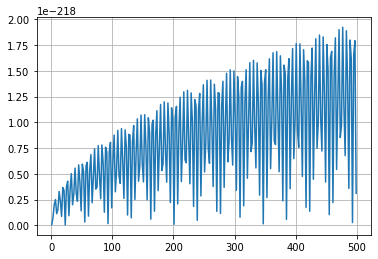

In [13]:
ROMBERG_BSCS = timed_bscs(*simargs, method=intg.romberg)

<font color=gray> There also is $\texttt{scipy.integrate.simps}$ to test, but it requires sampled data which is to be worked on later. </font>

Values of n computed from 1 to 499


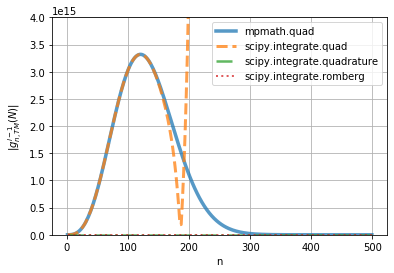

In [14]:
bsclsts = {
    "mpmath.quad": MPMATH_BSCS,
    "scipy.integrate.quad": QUAD_BSCS,
    "scipy.integrate.quadrature": QUADRATURE_BSCS,
    "scipy.integrate.romberg": ROMBERG_BSCS
}
linestyles = {}
l0 = 3.5
stls = ['-', '--', '-.', ':']
for ind, key in enumerate(bsclsts):
    linestyles[key] = {
        "linewidth": l0,
        "linestyle": stls[ind % len(stls)]
    }
    l0 = l0 - .5
    
nmin = m
ns = np.arange(nmin, nmax + 1, 2)
print("Values of n computed from", ns[0], "to", ns[-1])
plt.grid()
for name, lst in bsclsts.items():
    plt.plot(ns, lst, label=name, alpha=.75, **linestyles[name])
plt.legend()
plt.xlabel("n")
plt.ylabel("$\\left|g_{n, TM}^{l - 1}(N)\\right|$")
plt.ylim(top=4E15, bottom=0)
plt.show()

In sum, we have se following status for now (color code: <font color=green>tested as acceptable</font>, <font color=blue>seems acceptable</font>, <font color=red>pleasehelp</font>):
 - <font color=blue> $\texttt{mpmath.quad}$ </font> _(with suboptimal performance, maybe)_
 - <font color=red> $\texttt{scipy.integrate.quad}$</font> _(even though results <font color=blue>seem to hold</font> for $n < n_{problem}\approx 150$)_
 - <font color=red> $\texttt{scipy.integrate.quadrature}$ </font>
 - <font color=red> $\texttt{scipy.integrate.romberg}$ </font>

### Thought process:

We need the following function represented by $\texttt{gammaprod}$ in the $\texttt{mpmath}$ package:

$$ \texttt{gammaprod}(\textbf{u}, \textbf{v})  = \frac{\Gamma(u_1) \cdot \Gamma(u_2) \cdot\ldots\cdot \Gamma(u_n)}{\Gamma(v_1) \cdot \Gamma(v_2) \cdot\ldots\cdot \Gamma(v_m)}$$

For more info see <a href="http://mpmath.org/doc/current/functions/gamma.html#gammaprod">entry</a> in $\texttt{mpmath}$ documentation.

Also note that here we will compute harmonic modes in the $N$-convention, meaning we must not forget to convert the BSCs to the $P$-convention via:

$$g_{n, TX}^m (P) = (-1)^{n + 1} g_{n, TX}^{-m} (N)^*.$$

In [15]:
# N-convention _ TM LFLG BSC _ m = l - 1 finite series
def nconv_tmlflgbsc_lm1fs(n, m, **parameters):
    pass

# [P-convention _] TM LFLG BSC _ m = l - 1 finite series
def tmlflgbsc_lm1fs(n, m, **parameters):
    return (-1 ** (n + 1)) * nconv_tmlflgbsc_lm1fs(n, -m, **parameters)

#### Case (ii): $m = l - 1, l > 0$
$$    \left[ g_{n, TM}^{l-1}(N) \right]_p = i^n \frac{\sqrt{\pi}}{2^{l}} (-1)^{\frac{n - l + 1}{2}} \frac{\Gamma\left( \frac{n - l + 3}{2} \right)}{\Gamma\left( \frac{n + l}{2} \right)}
    \sum_{q=0}^{\leq n / 2} 2^{\frac{1}{2}+n - 2q} \frac{\Gamma\left(\frac{1}{2}+n-q\right)}{q!} \left[ b_{n-2q} \right]_p$$

## Problem solving

Something happened in different methods of integration. Let's find out:

$$ a(\eta) = \sqrt{2}\frac{R_f}{kw_0} \eta = \sqrt{2} R_f s \eta $$ <br>
$$ A_{l0}^j= \int_0^{k\text{NA}} \frac{\eta^{|l| + 1}}{(k^2 - \eta^2)^{\frac{1}{4}}} \exp\left( -\frac{a(\eta)^2}{2} \right) \left( 1 + \frac{\sqrt{k^2 - \eta^2}}{k} \right) \left( \frac{\eta}{k} \right)^{j - 1} \text{d}\eta $$ <br>
$$ A_{lp}^j= \int_0^{k\text{NA}} \frac{\eta^{|l| + 1}}{(k^2 - \eta^2)^{\frac{1}{4}}} a(\eta)^2 L_{p-1}^l\left(a(\eta)^2\right) \exp\left( -\frac{a(\eta)^2}{2} \right) \left( 1 + \frac{\sqrt{k^2 - \eta^2}}{k} \right) \left( \frac{\eta}{k} \right)^{j - 1} \text{d}\eta $$

In [16]:
def a(eta):
    return mpmath.sqrt(2) * r_focus / k / w0 * eta
a(na)

mpf('0.000066820351589785206390909357468025590338791176126779937')

In [17]:
def integrand(eta, l, p, j, kind='A'):
    pm = 1 if kind == 'A' else -1
    laguerre_term = 1
    if p > 0:
        laguerre_term = a(eta) ** 2 * mpmath.laguerre(p - 1, l, a(eta) ** 2)
        
    return ( mpmath.power(eta, np.abs(l) + 1) / mpmath.power(k ** 2 - eta ** 2, .25) \
           * laguerre_term * mpmath.exp(-(a(eta) ** 2 / 2 )) \
           * (1 + pm * mpmath.sqrt(k ** 2 - eta ** 2) / k) \
           * mpmath.power(eta / k, j - 1) )

In [18]:
def eval_integral(l, p, j, kind='A', delta=1, method=mpmath.quad):
    def argument(eta):
        return integrand(eta, l, p, j, kind=kind)
    npintg = np.frompyfunc(argument, 1, 1)
    if method is mpmath.quad:
        return mpmath.quad( argument, [0, k * na * delta] )
    if method is intg.quad:
        return intg.quad( argument, 0, k * na * delta )

In [19]:
def integral_performance(nmin=m, nmax=nmax, method=mpmath.quad):
    aquad_lst = []
    bquad_lst = []
    ns = np.arange(nmin, nmax + 1, 2)
    stt = time.time()
    fig, axes = plt.subplots(ncols=2)
    print("Evaluating", method.__module__, method.__name__, "for", len(ns), "values... (twice)")
    for j in ns:
        aquad_lst.append( mpmath.norm(eval_integral(l, p, j, method=method, kind='A')) )
        bquad_lst.append( mpmath.norm(eval_integral(l, p, j, method=method, kind='B')) )
    fin = time.time()
    axes[0].plot(ns, aquad_lst)
    axes[1].plot(ns, bquad_lst)
    plt.grid()
    plt.show()
    print(". Evaluated", method.__module__, method.__name__, "in", (fin - stt), "seconds.")
    return aquad_lst, bquad_lst

Evaluating mpmath.calculus.quadrature quad for 250 values... (twice)


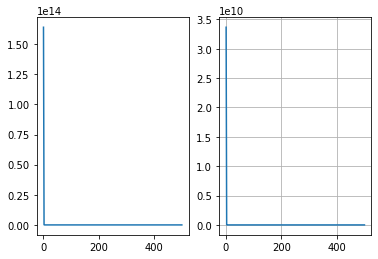

. Evaluated mpmath.calculus.quadrature quad in 12.934394121170044 seconds.


In [20]:
mpmathint = integral_performance(method=mpmath.quad)

Evaluating scipy.integrate.quadpack quad for 250 values... (twice)


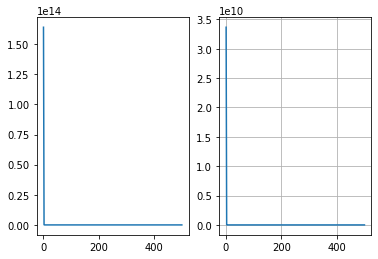

. Evaluated scipy.integrate.quadpack quad in 5.20099663734436 seconds.


In [21]:
quadint = integral_performance(method=intg.quad)

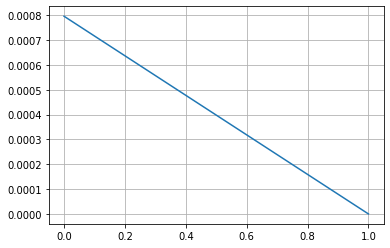

In [22]:
difs = []
for i, v in enumerate(mpmathint):
    difs.append(np.abs(mpmathint[0][i] - quadint[0][i]) ** 2)
plt.plot(difs)
plt.grid()
plt.show()

From what I see here, $\texttt{scipy.integrate.quad}$ might not have to explode as seen in the cells above only because of the integration. This could be one of two cases:<br>
 - The ever-so-slight differences in results the cell directly above show become very significant somewhere down the line as error propagates, or
 - We have somehow results shown in smaller precision in the $\texttt{scipy.integrate.quad}$ case.

### Doodles

Trying to figure out some stuff about decorators...

In [23]:
def zero(*args, **kwargs):
    return 0
def epsilonized(inname, outname):

    def find_arg_with_name(name, arglist, func_args=[], func_kwargs={}):
        value = fkwargs.get(name)
        if value is None:
            return func_args[arglist.index(name)]
        return value

    def decorator_eps(func):
        def epsilonized_func(*args, **kwargs):
            j = find_arg_with_name(
                inname, inspect.getfullargspec(func),
                func_args=args, func_kwargs=kwargs
            )
            if j in A:
                value = 0
            else:
                value = func(*args, **kwargs)
            return value
        return epsilonized_func
    return decorator_eps

Quadrature integration from $\texttt{scipy.integrate}$

In [24]:
def foo(x, a, b=0):
    return a * x + b

intg.quad(foo, 0, 1, args=(1, 1)) # args are processed in order; even kwargs

(1.5, 1.6653345369377348e-14)

In [25]:
d = {1: 2, 3: 4}
tuples = d.items()
print(tuples)

print(enumerate(d))
for i in enumerate(d):
    print(i)

dict_items([(1, 2), (3, 4)])
(0, 1)
(1, 3)


In [26]:
kw = {1: 2}
kw.items()

dict_items([(1, 2)])

In [27]:
def foo(x, a, b=0):
    return a * x + b

def bar(x):
    return foo(x, 2, b=1)

mpmath.quad(bar, [0, 1])

mpf('2.0')

In [28]:
# Testing the "timed" decorator
@timed
def timed_foo(x):
    for _ in range(x):
        time.sleep(1)

timed_foo(1)

m

> Evaluating timed_foo ...
> timed_foo evaluated in 1.001002311706543 seconds.


1

In [29]:
MPMATH_BSCS = QUADRATURE_BSCS = ROMBERG_BSCS = [0 for n in ns]

In [30]:
import pickle
# n-m even BSCs to dict
# tmbscdict = {(n = m + 2k, m): value of TM mode BSC}
quaddict = {}
i = m
for bsc in CONTROL_BSCS:
    quaddict[i, m] = bsc
    i += 2
with open("quad_dict.pickle", "wb") as f:
    pickle.dump(quaddict, f)

Fun with $\texttt{sympy}$

In [31]:
import sympy as sym

In [32]:
_l, _p, _k, _lambda, _w0, _k = sym.symbols('l, p, k, lambda, w0, k')
_rf, _s = sym.symbols("R_f s")
_eta, _j = sym.symbols('eta j')
_na = sym.symbols('\\text{NA}')
class _a(sym.Function):
    @classmethod
    def eval(cls, x):
        return _rf * sym.sqrt(2) / _k / _w0 * x

In [33]:
def express(a, b, name):
    symb = sym.symbols(name)
    sol = sym.solve(a - symb, b)
    return (symb, sol[0])

In [34]:
A = sym.Integral(
    ( _eta ** (sym.Abs(_l) + 1) / (_k ** 2 - _eta ** 2) ** sym.Rational(1, 4) \
    * sym.exp(-_a(_eta) ** 2 / 2) \
    * (1 + sym.sqrt(_k ** 2 - _eta ** 2) / _k) \
    * (_eta / _k) ** (_j - 1)),
    (_eta, 0, _k * _na)
)
af = sym.Function('a')
A.subs(_a(_eta), af(_eta))

Integral(eta**(Abs(l) + 1)*(eta/k)**(j - 1)*(1 + sqrt(-eta**2 + k**2)/k)*exp(-R_f**2*eta**2/(k**2*w0**2))/(-eta**2 + k**2)**(1/4), (eta, 0, \text{NA}*k))

In [35]:
A

Integral(eta**(Abs(l) + 1)*(eta/k)**(j - 1)*(1 + sqrt(-eta**2 + k**2)/k)*exp(-R_f**2*eta**2/(k**2*w0**2))/(-eta**2 + k**2)**(1/4), (eta, 0, \text{NA}*k))

In [ ]:
lgbeam = LGBeamFS()
m = l - 1
ll = []
ns = np.arange(1, 10)
for n in ns:
    ll.append(mpmath.norm(lgbeam.tmbsc_lm1(n)))
plt.plot(ns, ll)
plt.show()
ll